In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install fasttext

    !git clone https://github.com/MartinKirkegaardDK/KDS_MI.git

    if not has_changed_dir:
        os.chdir('KDS_MI')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True

In [2]:
from drivers import (
    plot_outlier_neurons, preprocessing,probe_confidence_intervals,
    steering, create_steering_vectors,
    steering_loss,
    distance_plots,
    create_average_activation_vectors,
    visualising_steering_vectors,
    visualising_activations,
    visualize_probe_results,
    create_bible_data,
    process_bible_data,
    visualize_bible_study,
    probe_confidence_intervals_NEW,
    scandeval_results,
    create_neuron_contributions,
    text_visualization
    
)

from pathlib import Path


In [4]:

all_languages = ["nb","is","da","en","sv"]
model_name="downloaded_models/gpt_gptsw3_en_da_is_356m_gbs1024"
model_name = "EleutherAI/pythia-14m"
model_name = "AI-Sweden-Models/gpt-sw3-356m"

hook_points = ["layernorm_1-pre","attention-pre","attention-post","layernorm_2-pre","mlp-pre","mlp-post"]


not_target_languages = []
target = "da"



if "download" in model_name:
    model_name_temp = model_name.split("/")[-1]
    for split in model_name.split("_"):
        if (split in all_languages) and (split !=target):
            not_target_languages.append(split)
else:
    
    model_name_temp = model_name.split("/")[-1]
    model_name_temp = model_name_temp.replace("-","_")
    not_target_languages = [lang for lang in all_languages if lang != target]

In [ ]:
model_name_temp

In [ ]:
#!zip -r zipped.zip results/data/probe_confidence_intervals

## Data preprocessing

Preprocesses the multilingual data, by removing short sentences

In [ ]:
preprocessing.run()

## Analysis of residual stream activations

### PCA of activations

In [ ]:

visualising_activations.run(model_name=model_name)

### Classification probes

In [ ]:
#This takes a long time to run
probe_confidence_intervals.run(
    model_name=model_name,
    reg_lambdas=[0.1, 0.5, 1, 2, 5, 10]
)

In [ ]:
visualize_probe_results.run(
    probe_result_path_by_reg_lambda={
        0.1: f'results/data/probe_confidence_intervals/gpt_sw3_356m_attention:post_reg_lambda_0.1.json',
    },
    model_name= model_name_temp
    
)

In [ ]:
lambdas = [0.1, 0.5, 1, 2, 5, 10]
#for reg in lambdas:
for hook_point in hook_points:
    visualize_probe_results.run(
        probe_result_path_by_reg_lambda={
            0.1: f'results/data/probe_confidence_intervals/{model_name_temp}_{hook_point}_reg_lambda_0.1.json',
            0.5: f'results/data/probe_confidence_intervals/{model_name_temp}_{hook_point}_reg_lambda_0.5.json',
            1: f'results/data/probe_confidence_intervals/{model_name_temp}_{hook_point}_reg_lambda_1.json',
            2: f'results/data/probe_confidence_intervals/{model_name_temp}_{hook_point}_reg_lambda_2.json',
            5: f'results/data/probe_confidence_intervals/{model_name_temp}_{hook_point}_reg_lambda_5.json',
            10: f'results/data/probe_confidence_intervals/{model_name_temp}_{hook_point}_reg_lambda_10.json',
        },
        model_name= model_name_temp
        
    )

## Create average activation vectors
these are the "base" steering vectors e.i. the average activations for different layers and languages.
This function generates them and the next block then splits them up for the analysis section.
Additionally, it also saves all the raw activations: raw_activations/\*model_name\*

In [ ]:
model_name_temp

In [ ]:
#create_average_activation_vectors.run(["nb","is","da","en","sv"],model_name= model_name,run_name = model_name_temp)



create_average_activation_vectors.run([target] + not_target_languages,model_name= model_name,run_name = model_name_temp)

## Create steering vector
these are the steering vectors towards a specific language. This is different that

In [ ]:
#AI-Sweden-Models/gpt-sw3-356m

create_steering_vectors.run(
    model_name=model_name_temp,
    target_language=target,
    complement_languages=not_target_languages
)

## plots the distance plots

/Users/marki/Documents/GitHub/KDS_MI/utils/distance_plots.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  steering_vector = torch.load(str(path + file))


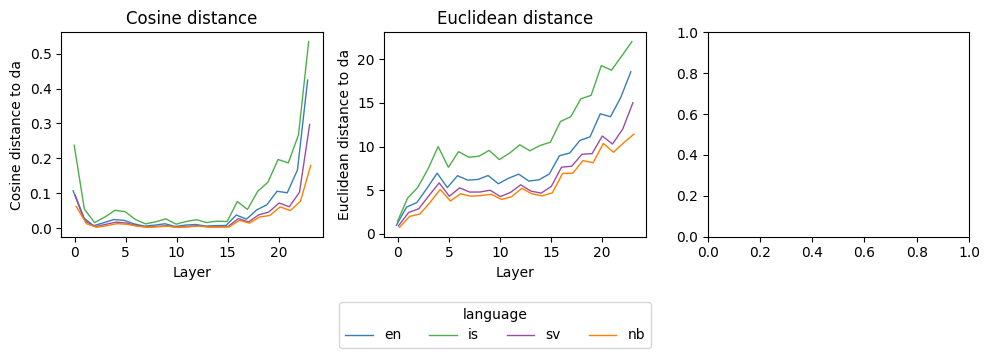

In [5]:

distance_plots.run(model_name_temp, target,f"average_activation_vectors/{model_name_temp}/","cosine")

## Test steering vectors

In [ ]:
layer = 5

steering_vector_path = f"steering_vectors/{model_name_temp}/combined_steering_vector_layer_{layer}_tensor.pt"

steering.run(
    steering_vector_path=steering_vector_path,
    steering_lambda=5,
    affected_language="en",
    layer=layer,
    model_name=model_name,
    data_folder='data/preprocessed/train'
)

## Measure steering vector loss impact

In [ ]:
#This also takes some time to run
steering_vector_folder = f'steering_vectors/{model_name_temp}'

steering_loss.run(
    steering_vector_folder=steering_vector_folder,
    model_name=model_name,
    model_name_temp=model_name_temp,
    lan1='en',
    lan2='da'
)

## Plot steering vector PCAs

steering_vector_folder = Path('steering_vectors/')

visualising_steering_vectors.run(
    steering_vector_paths_by_language={
        'en': lambda layer: steering_vector_folder / f'EN/combined_steering_vector_layer_{layer}_tensor.pt',
        'da': lambda layer: steering_vector_folder / f'DA/combined_steering_vector_layer_{layer}_tensor.pt',
        'sv': lambda layer: steering_vector_folder / f'SV/combined_steering_vector_layer_{layer}_tensor.pt',
        'nb': lambda layer: steering_vector_folder / f'NB/combined_steering_vector_layer_{layer}_tensor.pt',
        'is': lambda layer: steering_vector_folder / f'IS/combined_steering_vector_layer_{layer}_tensor.pt'
    },
    hidden_layers=24
)

In [ ]:
steering_vector_folder = Path('steering_vectors/')

visualising_steering_vectors.run(
    steering_vector_paths_by_language={
        'en': lambda layer: steering_vector_folder / f'EN/combined_steering_vector_layer_{layer}_tensor.pt',
        'da': lambda layer: steering_vector_folder / f'DA/combined_steering_vector_layer_{layer}_tensor.pt',
    },
    hidden_layers=24
)

## Bible study

In [ ]:
steering_vector_path = f"steering_vectors/{model_name_temp}/"
model_name = model_name
language1 = "da"
language2 = "en"
start_verse = 0
end_verse = 285
lambda_search_space = [0]

create_bible_data.run(model_name,language1,language2, steering_vector_path, lambda_search_space, start_verse,end_verse)


In [4]:
path = "results/data/steering_data_bible/"
language_label = "__label__dan"
process_bible_data.run(path, language_label)

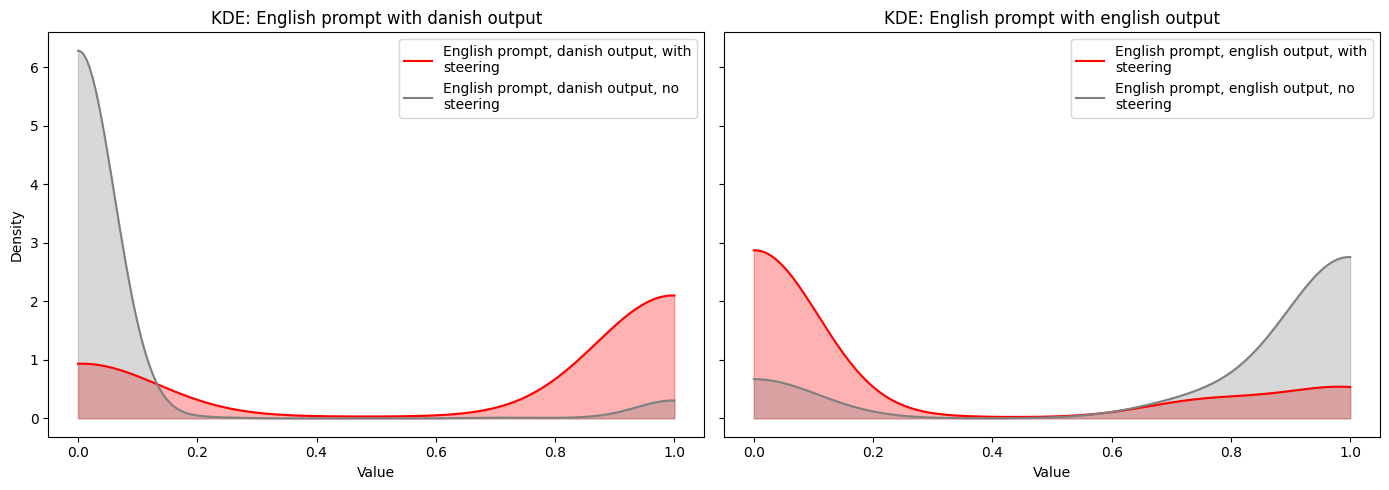

In [6]:
visualize_bible_study.run(
    file_path='results/data/steering_data_bible/bible_data_combined.csv',
    model_name_temp = model_name_temp
)

## ScandEval viz

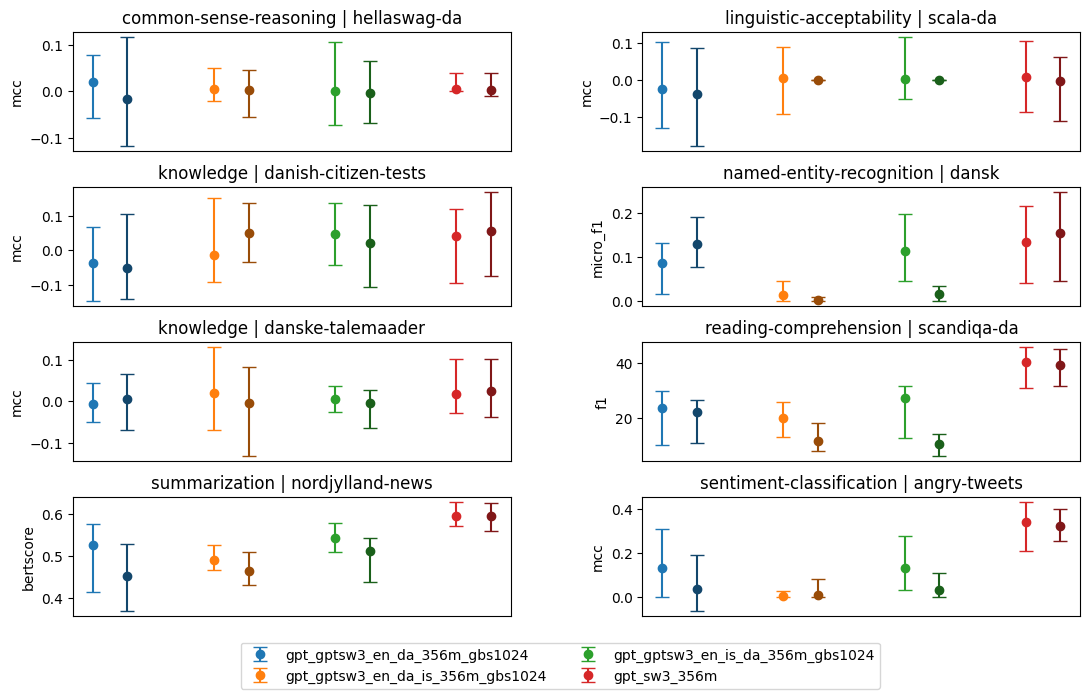

In [4]:
model_name_scandeval = ["gpt_sw3_356m","gpt_sw3_356m_with_steering_lambda_5",
                        "gpt_gptsw3_en_da_356m_gbs1024","gpt_gptsw3_en_da_356m_gbs1024_with_steering_lambda_5",
                        "gpt_gptsw3_en_is_da_356m_gbs1024","gpt_gptsw3_en_is_da_356m_gbs1024_with_steering_lambda_5",
                        "gpt_gptsw3_en_da_is_356m_gbs1024","gpt_gptsw3_en_da_is_356m_gbs1024_with_steering_lambda_5"]
df = scandeval_results.main("results/scandeval/scandeval_benchmark_results_den_gode.jsonl",model_name_scandeval)

##  Neuron contributions

In [ ]:
create_neuron_contributions.main(model_name, model_name_temp,hook_points,24)

In [ ]:
plot_outlier_neurons.main(24,hook_points, model_name_temp)

804, 807, 805

## Text visualization

In [ ]:
text = "The cat (Felis catus), also referred to as the domestic cat or house cat, is a small domesticated carnivorous mammal. It is the only domesticated species of the family Felidae. Advances in archaeology and genetics have shown that the domestication of the cat occurred in the Near East around 7500 BC."

text_visualization.main(model_name, model_name_temp,text,"da",15)

In [ ]:
text = "The cat (Felis catus), also referred to as the domestic cat or house cat, is a small domesticated carnivorous mammal. It is the only domesticated species of the family Felidae. Advances in archaeology and genetics have shown that the domestication of the cat occurred in the Near East around 7500 BC."
for layer in range(24):
    text_visualization.main(model_name, model_name_temp,text,"en",layer)
text = "Tamkatten (Felis catus[1][2] eller Felis silvestris catus[3]) er et lille, tæmmet, kødædende pattedyr oftest med pels. Den kaldes huskat eller bare kat, når der ikke er grund til at skelne den fra andre kattedyr. Katten er værdsat af mennesker for dens selskab og evne til at jage mus og rotter. Mange huskatte bliver op mod 20 år gamle."
for layer in range(24):
    text_visualization.main(model_name, model_name_temp,text,"da",layer)

In [ ]:
#KØR BIBLE STUDY MED ENGELSK PROMPT UDEN STEERING VECTOR SOME EN BASELINE